In [1]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from trade_metrics.metrics import Metrics
from torch.nn import LSTM, Linear, Module, Softmax
from scipy.optimize import minimize
from tqdm.auto import tqdm

sns.set_style('whitegrid')
sns.set_palette('Blues_r')
plt.rcParams['lines.linewidth'] = 1

In [2]:
# Data retrieval.

prices = pd.read_csv('data/VTI-AGG-DBC-VIX-prices.csv', index_col='Date', parse_dates=True)
returns = np.log(prices).diff()[1:]

In [3]:
# Aggregating the features (prices and returns).

data = pd.concat([prices.loc[returns.index], returns], axis=1)
data.head()

,AGG,DBC,VTI,^VIX,AGG,DBC,VTI,^VIX
Date,,,,,,,,
2007-01-04,100.120003,23.180000,70.114998,11.51,0.002100,-0.026396,0.001999,-0.045018
2007-01-05,100.050003,23.100000,69.559998,12.14,-0.000699,-0.003457,-0.007947,0.053290
2007-01-08,100.110001,23.219999,69.815002,12.00,0.000599,0.005181,0.003659,-0.011599
2007-01-09,100.110001,23.020000,69.815002,11.91,0.000000,-0.008651,0.000000,-0.007528
2007-01-10,100.000000,22.680000,69.970001,11.47,-0.001099,-0.014880,0.002218,-0.037643


In [4]:
# Defining dimensions for input and target.

seq_len = 50

n_assets = len(returns.columns)
n_samples = len(data[seq_len:])
n_features = len(data.columns)

print(f'''- Number of Assets: {n_assets}
- Length of Data: {len(data)}
- Length: {seq_len}
- Number of Samples: {n_samples} ({len(data)} - {seq_len}) 
- Number of features: {n_features} ({n_assets} assets x {n_features//n_assets} features)''')

- Number of Assets: 4
- Length of Data: 4175
- Length: 50
- Number of Samples: 4125 (4175 - 50) 
- Number of features: 8 (4 assets x 2 features)


In [5]:
# Creating input array (3D).

input_data = np.zeros((n_samples, seq_len, n_features))
target = returns.iloc[seq_len:].values[:n_samples]

for i in range(n_samples):
    input_data[i] = data.iloc[i:(i + seq_len)].values

print(f'''- Input shape: {input_data.shape}
- Target shape: {target.shape}''')

- Input shape: (4125, 50, 8)
- Target shape: (4125, 4)


In [6]:
# Defining the model architecture

class PortOptNN(Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PortOptNN, self).__init__()
        self.lstm = LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = Linear(hidden_dim, output_dim, bias=True)
        self.softmax = Softmax(dim=-1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out_last = lstm_out[:, -1, :]
        fc_out = self.fc(lstm_out_last)
        output = self.softmax(fc_out)
        return output
    
def objective(outputs, targets):
    portfolio_returns = (outputs * targets).sum(dim=1)
    mean_portfolio_return = portfolio_returns.mean()
    volatility = torch.std(portfolio_returns)
    sharpe_ratio = mean_portfolio_return / volatility
    return sharpe_ratio

In [7]:
# Defining Model Parameters

input_dim = input_data.shape[-1]
hidden_dim = 64
output_dim = target.shape[-1]

In [8]:
# Model training
epochs = 100
gains = []

model = PortOptNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), maximize=True)

train_input = input_data[:len(input_data)//2]; train_input_torch = torch.tensor(train_input, dtype=torch.float32)
train_target = target[:len(input_data)//2]; train_target_torch = torch.tensor(train_target, dtype=torch.float32)
test_input = input_data[len(input_data)//2:len(input_data)]; test_input_torch = torch.tensor(test_input, dtype=torch.float32)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_input_torch)
    gain = objective(outputs, train_target_torch)
    gain.backward()
    gains.append(gain.item())
    optimizer.step()
    print(f'{epoch + 1}/{epochs}: Gain: {gain.item()}', end='\r')

with torch.no_grad():
    test_outputs = model(test_input_torch)

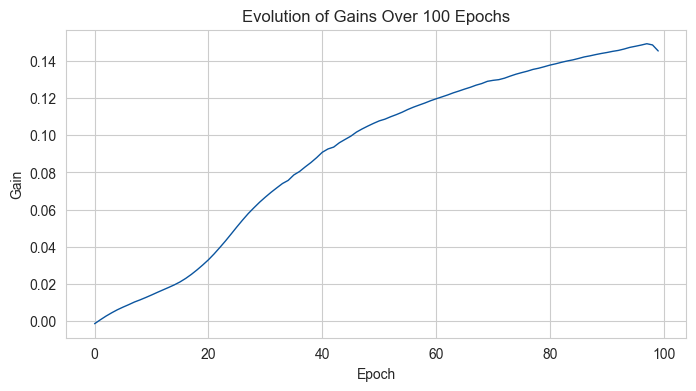

In [9]:
plt.figure(figsize=(8, 4))
sns.lineplot(gains)
plt.title('Evolution of Gains Over 100 Epochs')
plt.ylabel('Gain')
plt.xlabel('Epoch')
plt.show()

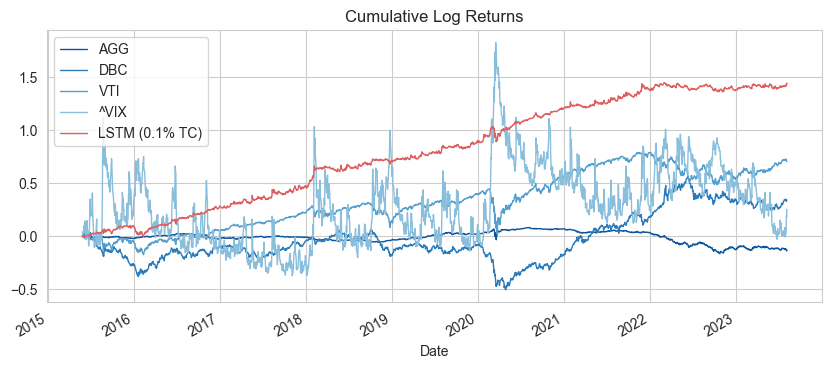

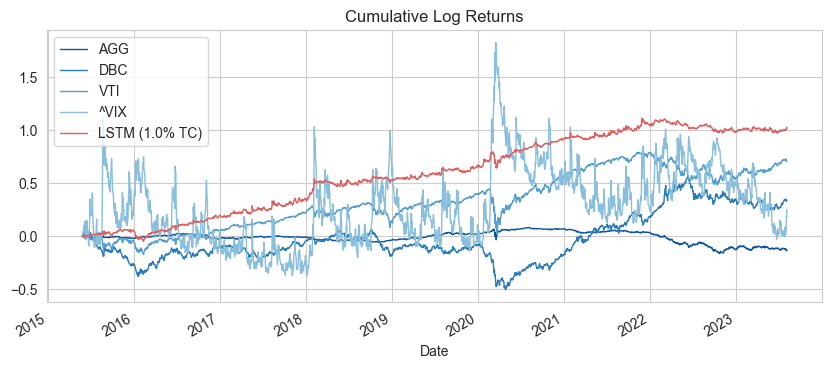

In [50]:
weights = pd.DataFrame(
    test_outputs, 
    index=returns.index[-len(test_outputs):],
    columns=returns.columns
).shift()

backtest_returns = returns.loc[weights.index].copy()
backtest_returns.loc[backtest_returns.index.min()] = {stock: 0 for stock in returns.columns}
model_returns = weights.multiply(backtest_returns).sum(axis=1)

def plot_with_tc(cost, model_returns, backtest_returns):
    transaction_costs_series = cost * (weights.diff().abs().sum(axis=1))
    model_returns_ = model_returns.copy()
    backtest_returns_ = backtest_returns.copy()
    model_returns_ -= transaction_costs_series
    backtest_returns_[f'LSTM ({cost*100}% TC)'] = model_returns_
    backtest_cumulative_returns = backtest_returns_.cumsum()
    ax = backtest_cumulative_returns.drop(columns=[f'LSTM ({cost*100}% TC)']).plot(figsize=(10, 4), legend=False)
    backtest_cumulative_returns[f'LSTM ({cost*100}% TC)'].plot(ax=ax, color='#DC6060')
    plt.legend(backtest_cumulative_returns.columns)
    plt.title('Cumulative Log Returns');

    return backtest_returns_

tc_001 = plot_with_tc(.001, model_returns, backtest_returns)
tc_01 = plot_with_tc(.01, model_returns, backtest_returns)

In [11]:
for ret in [tc_001, tc_01]:
    metrics = Metrics({col: ret[col] for col in ret.drop(columns='^VIX')})
    metrics = metrics.calculate()
    display(metrics.sort_values(by=['Cumulative Return', 'Sharpe Ratio'], ascending=False))

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
LSTM (0.1% TC),1.446491,0.176692,0.135740,1.154358,-0.143094
VTI,0.704880,0.086103,0.190475,0.347042,-0.430787
DBC,0.340160,0.041551,0.184910,0.116550,-0.568555
AGG,-0.130618,-0.015955,0.052660,-0.682784,-0.245053


,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
LSTM (1.0% TC),1.030418,0.125868,0.136050,0.778154,-0.152400
VTI,0.704880,0.086103,0.190475,0.347042,-0.430787
DBC,0.340160,0.041551,0.184910,0.116550,-0.568555
AGG,-0.130618,-0.015955,0.052660,-0.682784,-0.245053


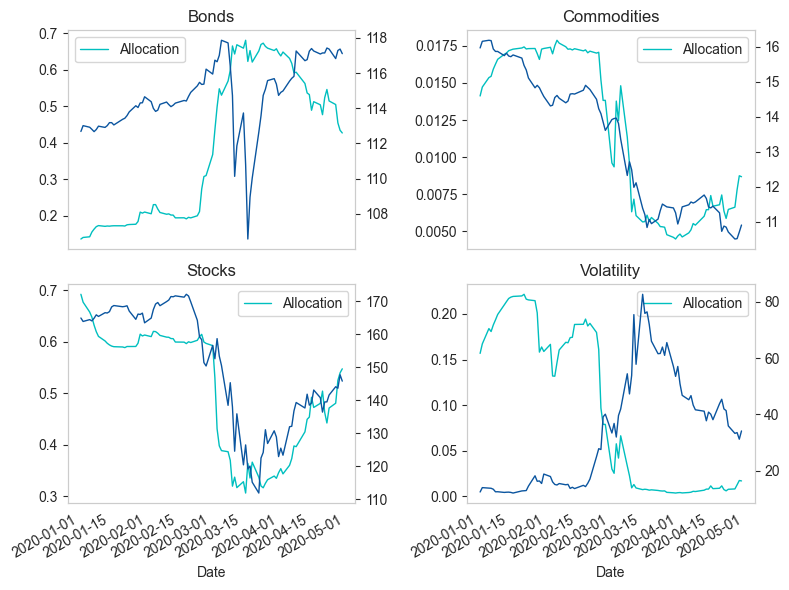

In [44]:
covid = weights.loc['2020-01':'2020-04']
fig, axes = plt.subplots(2, 2, figsize=(8,6), sharex=True)
invs = ['Bonds', 'Commodities', 'Stocks', 'Volatility']
axes = axes.flatten()
for i, ax in enumerate(axes):
    twinax = ax.twinx()
    covid[covid.columns[i]].plot(ax=ax, grid=False, color='c')
    prices.loc[covid.index][prices.columns[i]].plot(ax=twinax, grid=False)
    twinax.set_title(invs[i])
    ax.legend(['Allocation'])

plt.tight_layout()